In [1]:
using QuantumCollocation
using NamedTrajectories
using Optim
using TrajectoryIndexingUtils
using LinearAlgebra
using CairoMakie
using JLD2
using Revise
using ForwardDiff
using Distributions
using Plots

includet("../../SVD_RL_Methods.jl")

In [2]:
const Units = 1e9
const MHz = 1e6 / Units
const GHz = 1e9 / Units
const ns = 1e-9 * Units
const μs = 1e-6 * Units
;

In [3]:
# Operators
const Paulis = Dict(
    "I" => Matrix{ComplexF64}([1 0; 0 1]),
    "X" => Matrix{ComplexF64}([0 1; 1 0]),
    "Y" => Matrix{ComplexF64}([0 -im; im 0]),
    "Z" => Matrix{ComplexF64}([1 0; 0 -1]),
)

Dict{String, Matrix{ComplexF64}} with 4 entries:
  "Y" => [0.0+0.0im 0.0-1.0im; 0.0+1.0im 0.0+0.0im]
  "Z" => [1.0+0.0im 0.0+0.0im; 0.0+0.0im -1.0+0.0im]
  "I" => [1.0+0.0im 0.0+0.0im; 0.0+0.0im 1.0+0.0im]
  "X" => [0.0+0.0im 1.0+0.0im; 1.0+0.0im 0.0+0.0im]

In [4]:
G = exp(-im/2 *π*(kron(Paulis["Y"],Paulis["X"])+kron(Paulis["X"],Paulis["Y"])))
H_drives = [
    kron(Paulis["X"],Paulis["I"]),kron(Paulis["Y"],Paulis["I"]),
    kron(Paulis["I"],Paulis["X"]),kron(Paulis["I"],Paulis["Y"]),
    (kron(Paulis["X"],Paulis["X"])+kron(Paulis["Y"],Paulis["Y"]))/2
]
system = QuantumSystem(H_drives);
t_f = 15* ns
n_steps = 51
times = range(0, t_f, n_steps)  # Alternative: collect(0:Δt:t_f)
n_controls=1
n_qubits=1;
Δt = times[2] - times[1]

0.3

In [5]:
### Generate Initial Trajectories 
PICO_max_iter = 500

# Shape the cost function with weights on states and controls
Q = 100.
R =1e-2

a_bound = 1.0
dda_bound = 1.0

ops = IpoptOptions()
ops.print_info_string = "yes"
ops.recalc_y = "yes"
ops.recalc_y_feas_tol = 1.0 ##down
ops.print_level = 0

p_op = PiccoloOptions()
p_op.verbose=false
p_op.pade_order=10
p_op.free_time=true
p_op.timesteps_all_equal=true

true

In [6]:
p  =UnitarySmoothPulseProblem(
    system,
    G,
    n_steps,
    Δt;
    ipopt_options = ops,
    piccolo_options=p_op,
    a_bound=a_bound,
    dda_bound=dda_bound,
    Q=Q,
    R=R,
)
solve!(p,max_iter=500)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [7]:
p_time = UnitaryMinimumTimeProblem(
    p;
)
solve!(p_time,max_iter=500)

In [8]:
Δt =  p_time.trajectory[:Δt][1] 

0.15000070599931511

In [9]:
a  = p_time.trajectory[:a]
dda  = p_time.trajectory[:dda]
data = accel_SVD_rollout(dda,system,n_steps,Δt; weighted_modes=true)

32-element Vector{Matrix{Float64}}:
 [0.0 -4.0957566226857164e-8 … -4.0807382877890045e-8 -3.4009884936638735e-22; 0.0 -3.4744223616534483e-9 … -5.291987804036489e-9 1.4958051245280924e-23; … ; 0.0 -0.02769453637750135 … -0.024953797124651112 8.255080811879837e-17; 0.0 -3.416244244942287e-7 … -2.712198329768759e-7 -2.1161706182797433e-21]
 [0.0 0.06267652727877754 … 0.06247094083031603 2.079843037323095e-16; 0.0 0.0052682636087450245 … 0.00806005651455471 2.446874161556582e-17; … ; 0.0 -1.5600695442417684e-8 … -1.4055325676582825e-8 -1.1375915086353624e-22; 0.0 1.2281840906441565e-7 … 1.3042512488923526e-7 5.367098399715556e-22]
 [0.0 3.6747539347146005e-5 … -6.279007151637707e-6 1.2378465321842641e-19; 0.0 -0.00014099415956719276 … -0.0001454115806309665 2.2361098645909287e-18; … ; 0.0 8.398926246013725e-5 … 7.396209872675642e-5 -1.5972213318506633e-19; 0.0 0.04267207679001237 … 0.04267750232172641 -5.887996717734285e-16]
 [0.0 -0.010574999796490825 … 0.0017850532101474571 1.891298348

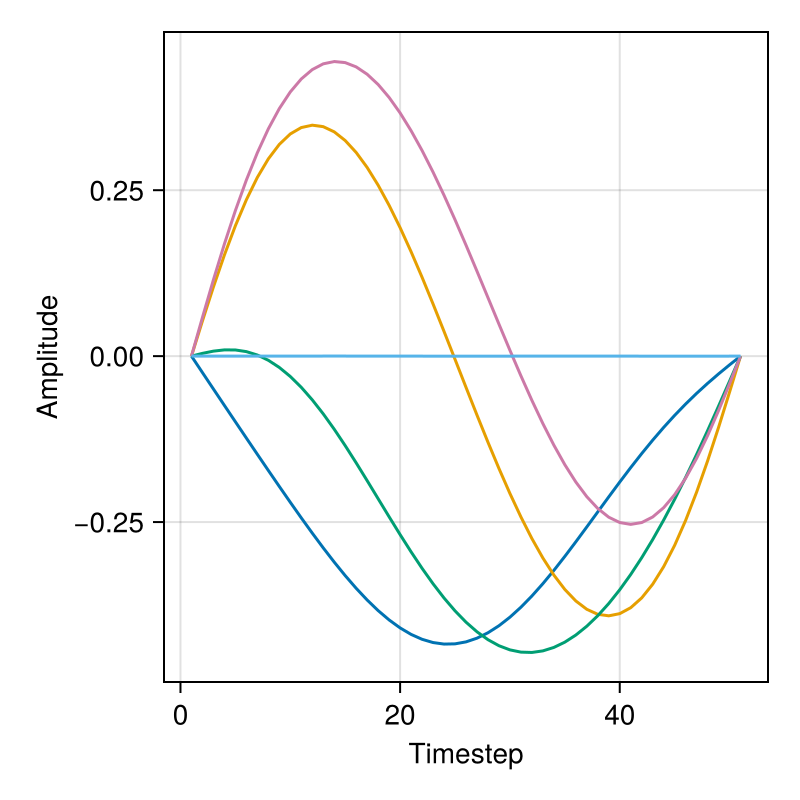

In [10]:
plot_data([a];figsize =(400,400))

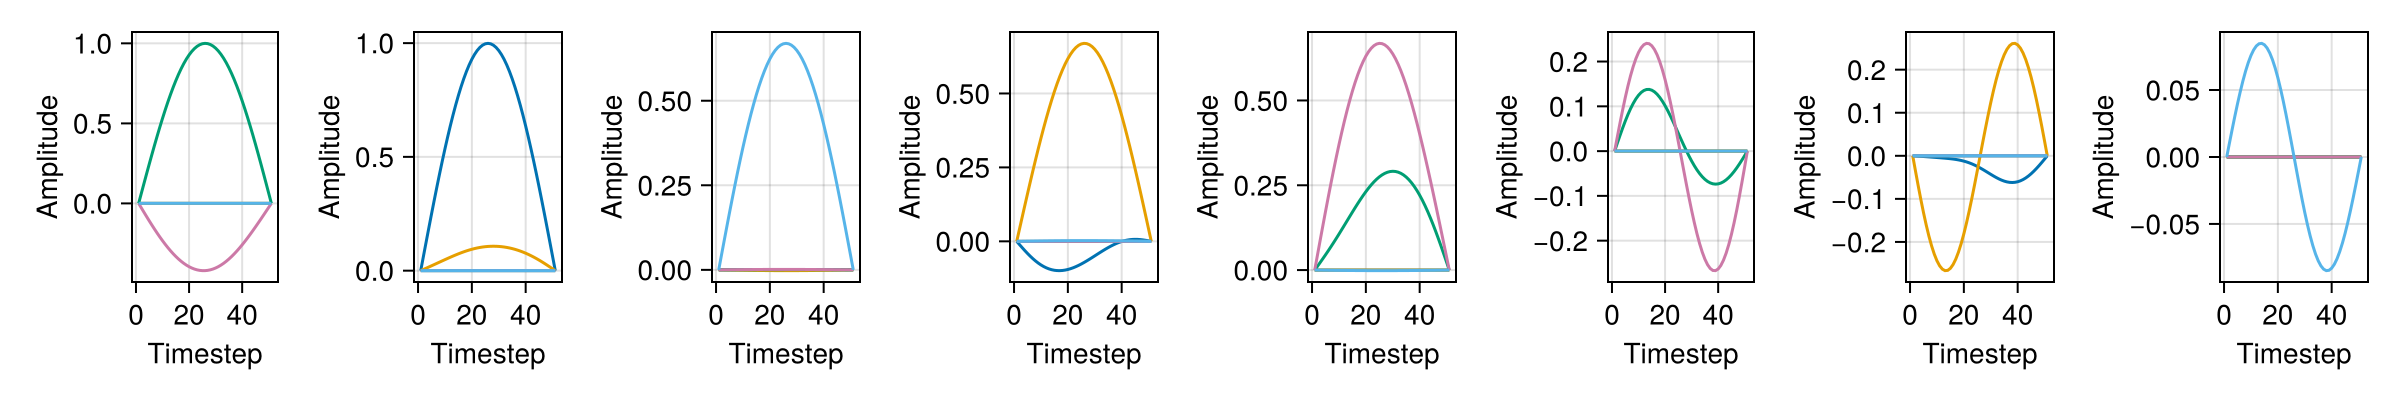

In [11]:
plot_data(data[1:8];figsize=(1200,200))

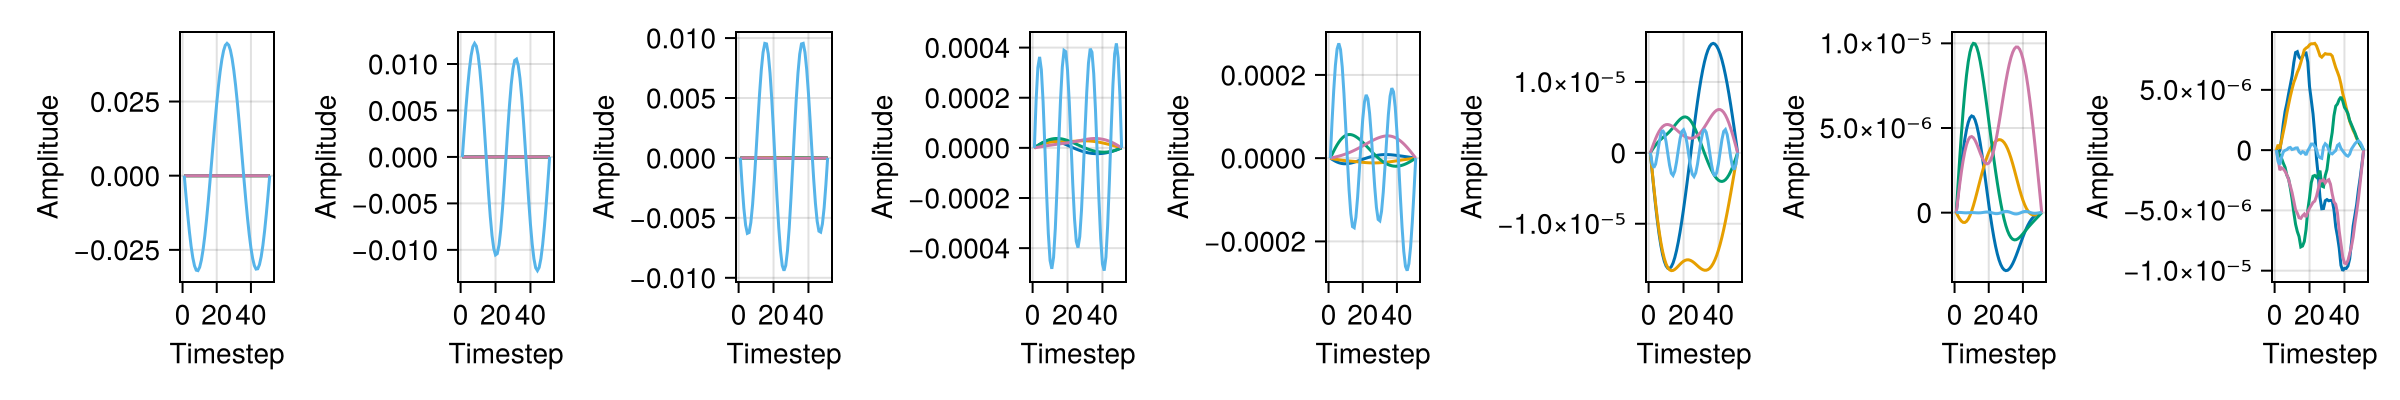

In [12]:
plot_data(data[9:16];figsize=(1200,200))

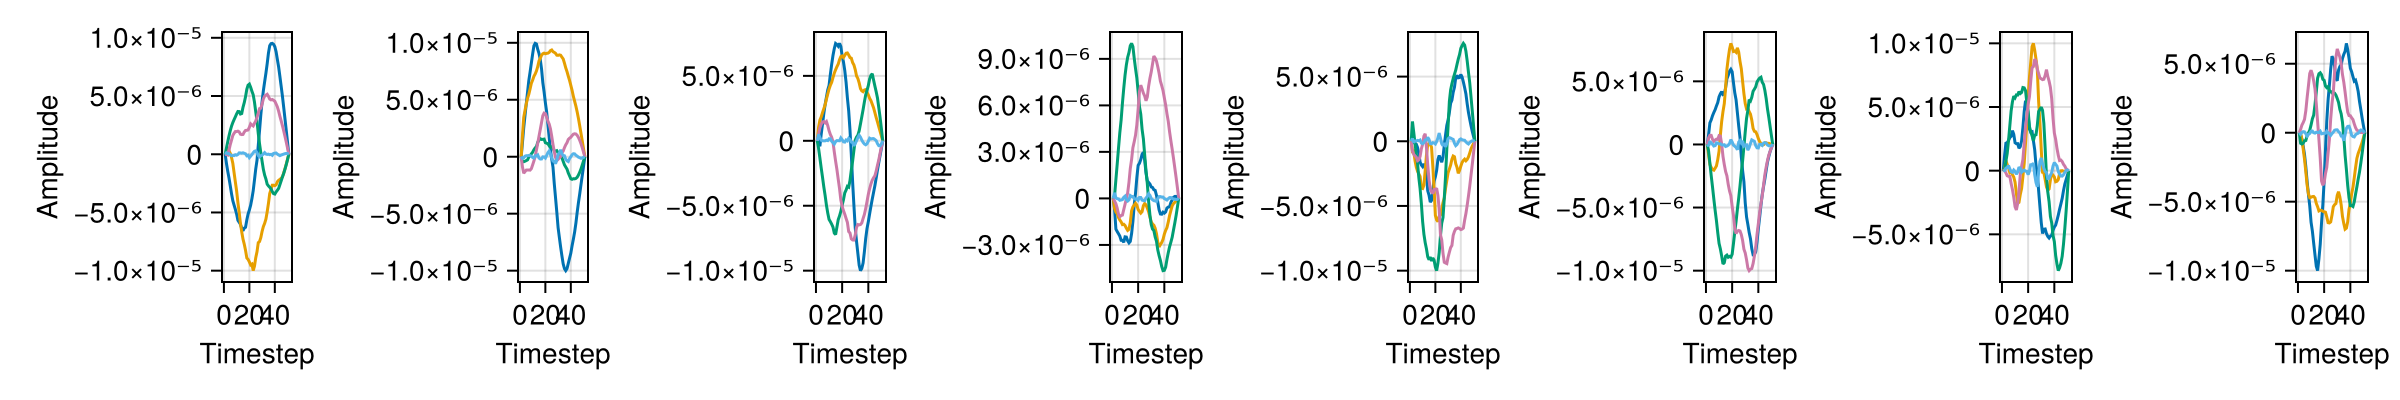

In [13]:
plot_data(data[17:24];figsize=(1200,200))

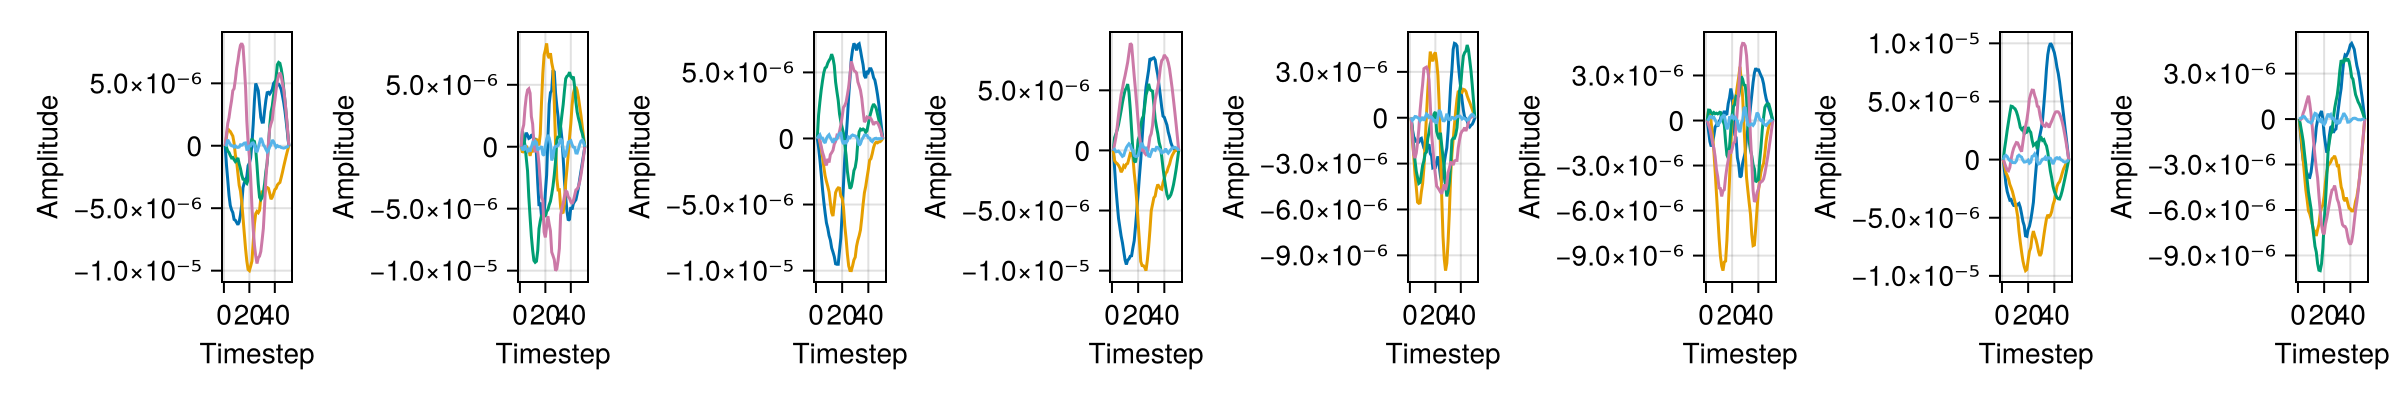

In [14]:
plot_data(data[25:32];figsize=(1200,200))

In [15]:
ϵ1 = 0.05
history1 = []
for i ∈ 1:20
    ϵ = rand(Uniform(-ϵ1,ϵ1),length(system.H_drives))
    system2 = perturb_system(system,ϵ)
    push!(history1,neadler_mead_opt(16,a,data,system2, n_steps,Δt,G;iterations=3000)[1])
end

In [16]:
ϵ2 = 0.15
history2 = []
for i ∈ 1:20
    ϵ = rand(Uniform(-ϵ2,ϵ2),length(system.H_drives))
    system2 = perturb_system(system,ϵ)
    push!(history2,neadler_mead_opt(16,a,data,system2, n_steps,Δt,G;iterations=3000)[1])
end

In [17]:
ϵ3 = 0.25
history3 = []
for i ∈ 1:20
    ϵ = rand(Uniform(-ϵ3,ϵ3),length(system.H_drives))
    system2 = perturb_system(system,ϵ)
    push!(history3,neadler_mead_opt(16,a,data,system2, n_steps,Δt,G;iterations=3000)[1])
end

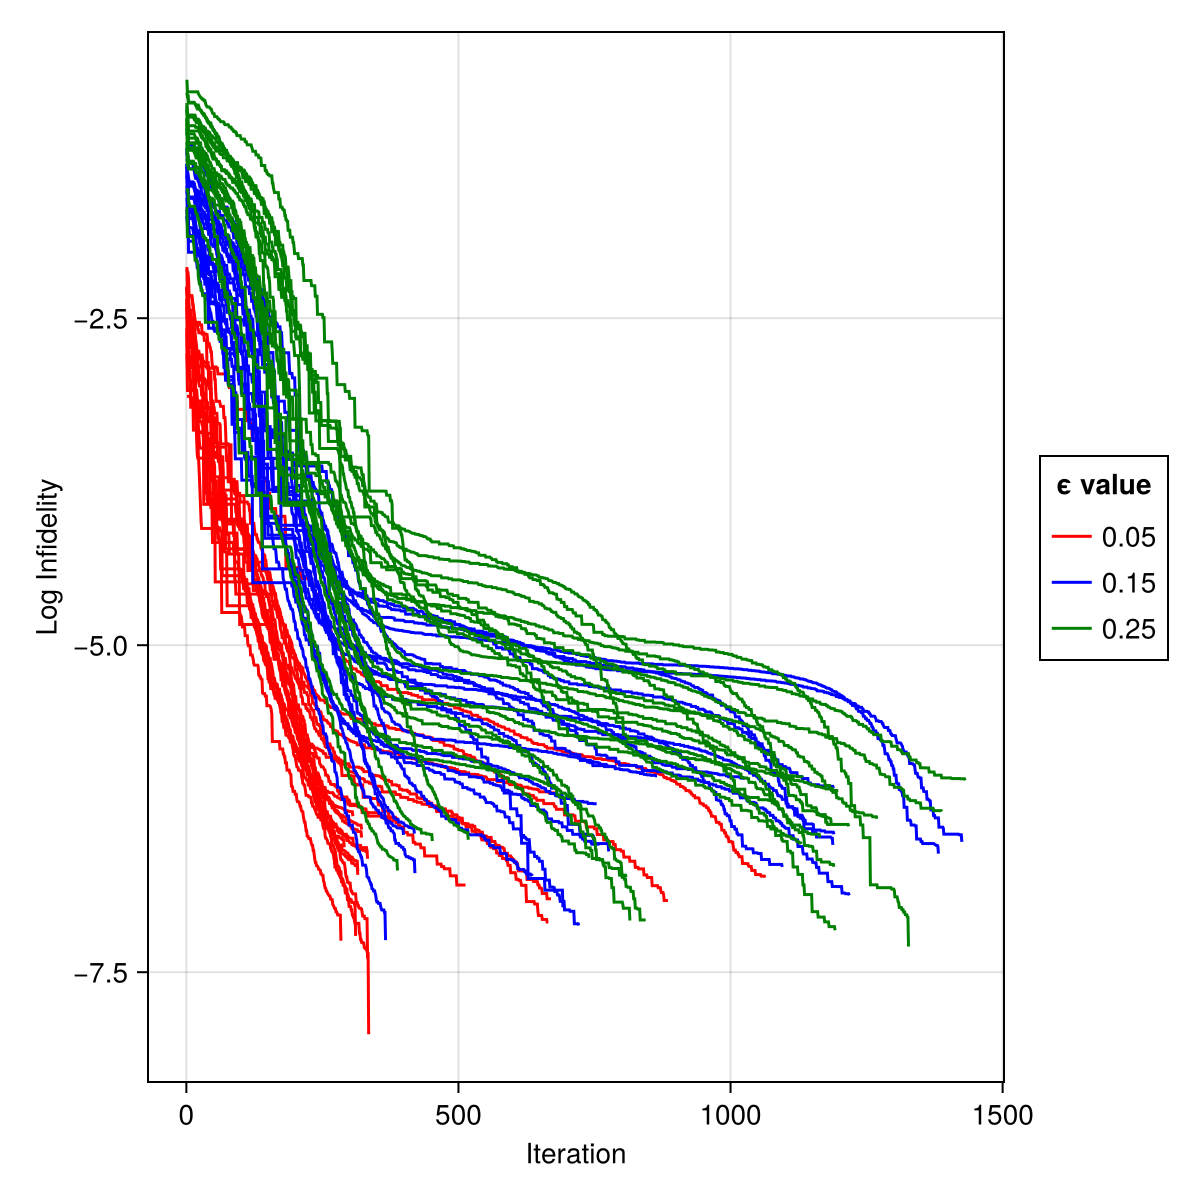

In [18]:
f = Figure(size =(600,600))
ax = Axis(f[1, 1],xlabel="Iteration",ylabel="Log Infidelity")
r=nothing
b=nothing
g=nothing
for (idx,h) ∈ enumerate(history1)
    r = lines!(log10.(h),label=string(idx),color=:red)
end

for (idx,h) ∈ enumerate(history2)
    g = lines!(log10.(h),label=string(idx),color=:blue)
end

for (idx,h) ∈ enumerate(history3)
    b = lines!(log10.(h),label=string(idx),color=:green)
end
Legend(f[1, 2],
    [r, g,b],
    ["0.05","0.15","0.25"],
    "ϵ" * " value")

f